# Run full Granual Predictions

What needs to happen:
- function to temporally and spatially interpolate MERRA2 
- function to read MERRA2 with interpolation
  - PS = surface_pressure
  - T10M = 10-meter_air_temperature (Andy will investigate)
  - TO3 = total_column_ozone
  - TQV = total_precipitable_water_vapor
- function to read VNP02MOD
  - observation_data
    - M14 (for center wavelengths at 8500 nm)
    - M15 (for center wavelengths at 10800 nm)
    - M16 (for center wavelengths at 12000 nm)
- function to read VNP03MOD
  - geolocation_data
    - sensor_azimuth
    - sensor_zenith
    - solar_azimuth
    - solar_zenith
- function to combine above for model inputs

## Setup

In [1]:
from pathlib import Path

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from hot_dust import preprocess, DATADIR

In [41]:
open_vnp02 = xr.open_dataset(
    "data/granules/VNP02MOD.A2020168.1448.002.2021127084950.nc",
    group="observation_data",
    mask_and_scale=False,
)

# Access the relavant variables
vnp02_variables = open_vnp02[
    [
        "M14",
        "M14_brightness_temperature_lut",
        "M15",
        "M15_brightness_temperature_lut",
        "M16",
        "M16_brightness_temperature_lut",
    ]
]
open_vnp02

# call xr where and fill values less than oe equal to 65527
# xr stack and unstack 3D to 2D

<xarray.Dataset>
Dimensions:                         (number_of_lines: 3232,
                                     number_of_pixels: 3200,
                                     number_of_LUT_values: 65536,
                                     number_of_M13_LUT_values: 327681)
Dimensions without coordinates: number_of_lines, number_of_pixels,
                                number_of_LUT_values, number_of_M13_LUT_values
Data variables: (12/53)
    M01                             (number_of_lines, number_of_pixels) uint16 ...
    M01_quality_flags               (number_of_lines, number_of_pixels) uint16 ...
    M01_uncert_index                (number_of_lines, number_of_pixels) int8 ...
    M02                             (number_of_lines, number_of_pixels) uint16 ...
    M02_quality_flags               (number_of_lines, number_of_pixels) uint16 ...
    M02_uncert_index                (number_of_lines, number_of_pixels) int8 ...
    ...                              ...
    M15_brightness_temperature_lut  (number_of_LUT_values) float32 ...
    M15_uncert_index                (number_of_lines, number_of_pixels) int8 ...
    M16                             (number_of_lines, number_of_pixels) uint16 ...
    M16_quality_flags               (number_of_lines, number_of_pixels) uint16 ...
    M16_brightness_temperature_lut  (number_of_LUT_values) float32 ...
    M16_uncert_index                (number_of_lines, number_of_pixels) int8 ...

In [25]:
Dopen_vnp03 = xr.open_dataset(
    "data/granules/VNP03MOD.A2020168.1448.002.2021125194020.nc",
    group="geolocation_data",
)

# Access the relavant variables
vnp03_variables = open_vnp03[
    ["sensor_azimuth", "sensor_zenith", "solar_azimuth", "solar_zenith"]
]

In [42]:
# Merge the model imputs
vnp02_vnp03 = xr.merge([vnp02_variables, vnp03_variables])
print(vnp02_vnp03)

# Access the relavant variables
M14_ds = vnp02_vnp03["M14"]  # thermal infared wave length
M14_BTL_ds = vnp02_vnp03["M14_brightness_temperature_lut"]
M15_ds = vnp02_vnp03["M15"]  # thermal infared wave length
M15_BTL_ds = vnp02_vnp03["M15_brightness_temperature_lut"]
M16_ds = vnp02_vnp03["M16"]  # thermal infared wave length
M16_BTL_ds = vnp02_vnp03["M16_brightness_temperature_lut"]

# Convert to brightness temperature in K
M14_scaled = vnp02_vnp03["M14_brightness_temperature_lut"][vnp02_vnp03["M14"]]
M15_scaled = vnp02_vnp03["M15_brightness_temperature_lut"][vnp02_vnp03["M15"]]
M16_scaled = vnp02_vnp03["M16_brightness_temperature_lut"][vnp02_vnp03["M16"]]

<xarray.Dataset>
Dimensions:                         (number_of_lines: 3232,
                                     number_of_pixels: 3200,
                                     number_of_LUT_values: 65536)
Dimensions without coordinates: number_of_lines, number_of_pixels,
                                number_of_LUT_values
Data variables:
    M14                             (number_of_lines, number_of_pixels) uint16 ...
    M14_brightness_temperature_lut  (number_of_LUT_values) float32 ...
    M15                             (number_of_lines, number_of_pixels) uint16 ...
    M15_brightness_temperature_lut  (number_of_LUT_values) float32 ...
    M16                             (number_of_lines, number_of_pixels) uint16 ...
    M16_brightness_temperature_lut  (number_of_LUT_values) float32 ...
    sensor_azimuth                  (number_of_lines, number_of_pixels) float32 ...
    sensor_zenith                   (number_of_lines, number_of_pixels) float32 ...
    solar_azimuth             

## Extract MERRA-2 Input Variables



In [ ]:
%%time
# opendap on station101, vscode timing == 7m 15.6s
# s3 on openscapes.2i2c.cloud, magics time == 1min 11s
# import earthaccess

# auth = earthaccess.login(strategy="netrc", persist=True)
# fs = earthaccess.get_s3fs_session("GES_DISC")
fs = None
granule = DATADIR / "granules"
for item in granule.glob("VNP03*"):
    ds = preprocess.get_merra_variables(item, fs)
    ds.to_netcdf(DATADIR / "merra" / item.name)

## 2D Plot of Input Variables

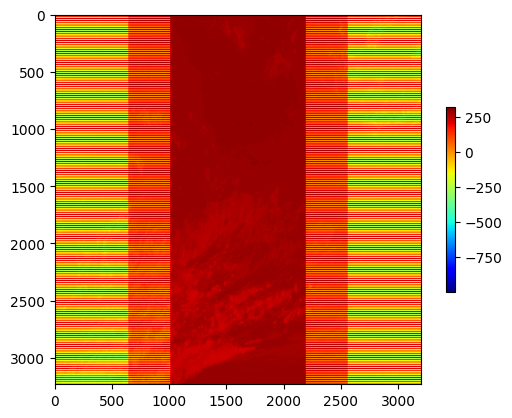

In [44]:
# M14 Map
plt.imshow(M14_scaled, cmap="jet")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()  # TODO mask fill values

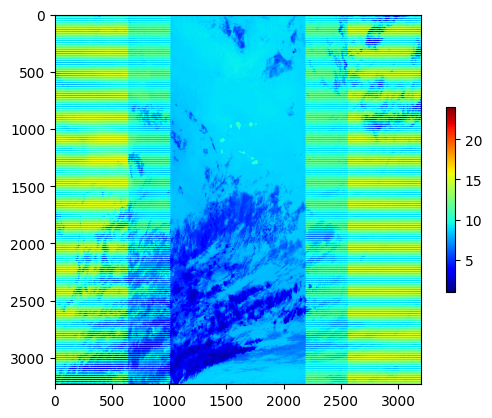

In [38]:
# M15 Map
plt.imshow(M15_ds, cmap="jet")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()

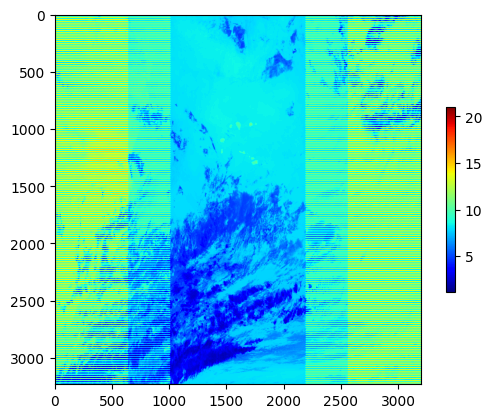

In [39]:
# M16 Map
plt.imshow(M16_ds, cmap="jet")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()

## 2D Plot of Predicted Dust Optical Thickness

## WIP / Scratch

In [ ]:
xr.open_dataset("data/rt_nn_irdust_training_data.nc")

<xarray.Dataset>
Dimensions:                 (npoints: 250000, nbands_viirs: 3)
Coordinates:
  * nbands_viirs            (nbands_viirs) float32 8.5e+03 1.08e+04 1.2e+04
Dimensions without coordinates: npoints
Data variables:
    solar_zenith_angle      (npoints) float32 ...
    viewing_zenith_angle    (npoints) float32 ...
    relative_azimuth_angle  (npoints) float32 ...
    viirs_bts               (nbands_viirs, npoints) float32 ...
    dust_optical_thickness  (npoints) float32 ...
    dust_central_height     (npoints) float32 ...
    spress                  (npoints) float32 ...
    h2o                     (npoints) float32 ...
    o3                      (npoints) float32 ...
    ws                      (npoints) float32 ...
    ts                      (npoints) float32 ...
Attributes:
    description:             Radiative transfer-based labelled training data ...
    suffix:                  nc
    version:                 20230803
    contact_person_address:  NASA/GSFC, Mail Code 616, 8800 Greenbelt Road, G...
    contact_person_email:     andrew.sayer@nasa.gov
    contact_person_name:      Andrew Sayer
    contact_person_role:     Scientific/technical contact
    data_set_language:       en
    file_format:             NetCDF4

In [ ]:
xr.open_dataset("data/granules/GMAO_MERRA2.20200616T140000.MET.nc")

<xarray.Dataset>
Dimensions:   (lat: 361, lon: 576)
Coordinates:
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Data variables:
    PS        (lat, lon) float32 ...
    QV10M     (lat, lon) float32 ...
    SLP       (lat, lon) float32 ...
    T10M      (lat, lon) float32 ...
    TO3       (lat, lon) float32 ...
    TQV       (lat, lon) float32 ...
    U10M      (lat, lon) float32 ...
    V10M      (lat, lon) float32 ...
    FRSNO     (lat, lon) float32 ...
    FRSEAICE  (lat, lon) float32 ...
Attributes: (12/39)
    date_created:                      2022-03-02T06:13:36Z
    title:                             GMAO MERRA2 2D Hourly,  Instantaneous,...
    product_name:                      GMAO_MERRA2.20200616T140000.MET.nc
    history:                           gmao_met_merge -asm MERRA2_400.inst1_2...
    time_coverage_start:               2020-06-16T14:00:00Z
    time_coverage_end:                 2020-06-16T14:00:00Z
    ...                                ...
    identifier_product_doi:            10.5067/3Z173KIE2TPD;10.5067/RKPHT8KC1...
    processing_level:                  L4
    cdm_data_type:                     grid
    spatialResolution:                 0.5x0.625 degrees
    source:                            MERRA2_400.inst1_2d_asm_Nx.20200616.nc...
    comment:                           This file contains a subset of variabl...